In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import json

def load_data(fp):
  with open(fp) as fid:
    series = (pd.Series(json.loads(s)) for s in fid)
    return pd.concat(series,axis=1).T

renththerunway_fp = "drive/My Drive/ML Project/renttherunway_final_data.json"
df = load_data(renththerunway_fp)
df.head()




,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


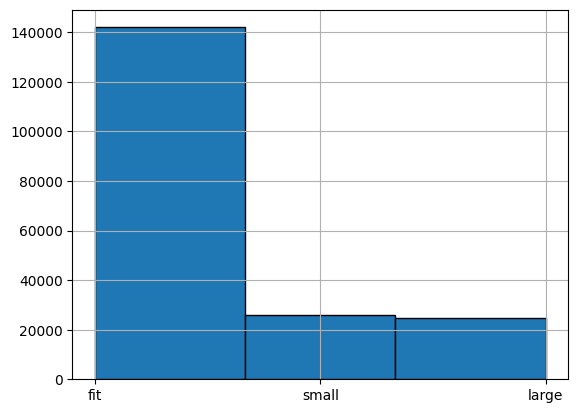

In [3]:
target_feature = 'fit'
n_classes = df[target_feature].unique().shape[0]
df[target_feature].hist(bins=n_classes, edgecolor='black');

In [4]:
#checking for null values and dropping them.
def check_nulls(data):
    for col in df:
        print(f'Column \'{col}\'. Is null - {data[col].isnull().sum()}')
      

to_drop = df[df['fit'] == 'fit'].isnull().any(axis=1)
n = to_drop.sum()
to_drop.shape, df.shape
df = df.drop(df[df['fit'] == 'fit'][to_drop].index, axis=0)
print(f'Dropped {n} examples')

check_nulls(df)

Dropped 34325 examples
Column 'fit'. Is null - 0
Column 'user_id'. Is null - 0
Column 'bust size'. Is null - 4740
Column 'item_id'. Is null - 0
Column 'weight'. Is null - 7658
Column 'rating'. Is null - 19
Column 'rented for'. Is null - 1
Column 'review_text'. Is null - 0
Column 'body type'. Is null - 3734
Column 'review_summary'. Is null - 0
Column 'category'. Is null - 0
Column 'height'. Is null - 191
Column 'size'. Is null - 0
Column 'age'. Is null - 254
Column 'review_date'. Is null - 0


In [5]:
#converting height from feet to inches
def parse_ht(height):
    ht_ = height.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_
#converting weight from pounds to kilos.
def pounds_to_kilos(s):
    return int(s.replace('lbs', '')) * 0.45359237

df['height'] = (df['height']
                        .fillna("0' 0\"")
                        .apply(parse_ht))
df['height'][df['height'] == 0] = df['height'].median()

df['weight'] = (df['weight']
                        .fillna('0lbs')
                        .apply(pounds_to_kilos))
df['weight'][df['weight'] == 0.0] = df['weight'].median()

df['user_id'] = pd.to_numeric(df['user_id'])
df['bust size'] = df['bust size'].fillna(df['bust size'].value_counts().index[0])
df['body type'] = df['body type'].fillna(df['body type'].value_counts().index[0])
df['item_id'] = pd.to_numeric(df['item_id'])
df['size'] = pd.to_numeric(df['size'])

df['age'] = pd.to_numeric(df['age'])
df['age'] = df['age'].fillna(df['age'].median())

df['rating'] = pd.to_numeric(df['rating'])
df['rating'] = df['rating'].fillna(df['rating'].median())

df['review_date'] = pd.to_datetime(df['review_date'], format='%B %d, %Y')
#replacing null values of numeric features with median values.
df.info()

<ipython-input-5-358ba776fac2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['height'][df['height'] == 0] = df['height'].median()
<ipython-input-5-358ba776fac2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight'][df['weight'] == 0.0] = df['weight'].median()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158219 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             158219 non-null  object        
 1   user_id         158219 non-null  int64         
 2   bust size       158219 non-null  object        
 3   item_id         158219 non-null  int64         
 4   weight          158219 non-null  float64       
 5   rating          158219 non-null  float64       
 6   rented for      158218 non-null  object        
 7   review_text     158219 non-null  object        
 8   body type       158219 non-null  object        
 9   review_summary  158219 non-null  object        
 10  category        158219 non-null  object        
 11  height          158219 non-null  float64       
 12  size            158219 non-null  int64         
 13  age             158219 non-null  float64       
 14  review_date     158219 non-null  dat

In [6]:
#column mapper
col_mapper = {
    'bust size': 'bust_size',
    'weight': 'usr_weight_kg',
    'rating': 'review_rating',
    'rented for': 'rented_for',
    'body type': 'body_type',
    'category': 'product_category',
    'height': 'usr_height_inchs',
    'size': 'product_size',
    'age': 'usr_age',
}
df.rename(col_mapper, axis=1, inplace=True)


In [7]:
newdf = df.copy()

In [8]:
#bust size and category mapper
import re

def parse_bust_size(s):
    m = re.match(r'(\d+)([A-Za-z])(\+?)', s)
    if m:
        return pd.Series(data=[int(m.group(1)), m.group(2).lower()])
    return []

mapper = {
    0: 'bust_size_num', 
    1: 'bust_size_cat'
}

temp_df = newdf['bust_size'].apply(parse_bust_size).rename(mapper, axis=1)
temp_df['bust_size_num'] = pd.to_numeric(temp_df['bust_size_num'])
newdf = newdf.join(temp_df)
newdf.drop(['bust_size'], axis=1, inplace=True)

In [9]:
#bust category mapper
mapper = {
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
}
newdf['bust_size_cat'] = newdf['bust_size_cat'].map(mapper)

newdf.head()

,fit,user_id,item_id,usr_weight_kg,review_rating,rented_for,review_text,body_type,review_summary,product_category,usr_height_inchs,product_size,usr_age,review_date,bust_size_num,bust_size_cat
0,fit,420272,2260466,62.142155,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20,34,4
1,fit,273551,153475,59.874193,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18,34,2
3,fit,909926,126335,61.234970,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12,34,3
4,fit,151944,616682,65.770894,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26,34,2
5,fit,734848,364092,62.595747,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016-04-30,32,2


In [10]:
mapper = {
    'small': -1,
    'fit': 0,
    'large': 1,
}
newdf['fit'] = newdf['fit'].map(mapper)

,fit,usr_weight_kg,usr_height_inchs,product_size,usr_age,bust_size_num,bust_size_cat
fit,1.000000,-0.018683,-0.017217,-0.124194,-0.016582,-0.015816,-0.008531
usr_weight_kg,-0.018683,1.000000,0.377023,0.795841,0.062545,0.611228,0.283625
usr_height_inchs,-0.017217,0.377023,1.000000,0.235386,-0.003338,0.156887,0.013364
product_size,-0.124194,0.795841,0.235386,1.000000,0.161174,0.627775,0.297101
usr_age,-0.016582,0.062545,-0.003338,0.161174,1.000000,0.177865,0.067199
bust_size_num,-0.015816,0.611228,0.156887,0.627775,0.177865,1.000000,0.113405
bust_size_cat,-0.008531,0.283625,0.013364,0.297101,0.067199,0.113405,1.000000


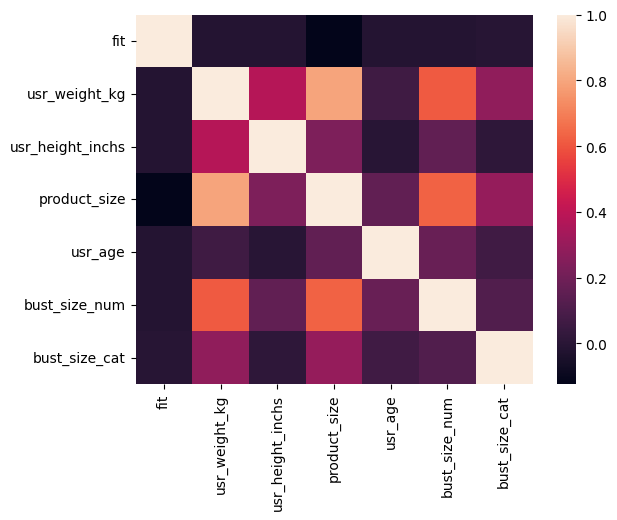

In [11]:
#Scaling the data and getting correlation matrix.
from sklearn.preprocessing import scale
import seaborn as sns

numeric_dtypes = {'int64', 'float64'}
numeric_features = [c for c in newdf.columns if str(newdf[c].dtype) in numeric_dtypes]
numeric_features.remove('user_id')
numeric_features.remove('item_id')
numeric_features.remove('review_rating')

cleaned_df_scaled = newdf[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix

In [12]:
print('Pairs of columns that have correlation greater than 0.5: ')
#finding columns which have correlation value greater than 0.5
lim = 0.5
corr_cols = []
for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if corr_matrix.iloc[i, j] > lim:
            pair = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_cols.append(pair)
            print('({}, {})'.format(*pair))
            
print('These columns are to be inspected more closely')
corr_cols

Pairs of columns that have correlation greater than 0.5: 
(usr_weight_kg, product_size)
(usr_weight_kg, bust_size_num)
(product_size, bust_size_num)
These columns are to be inspected more closely


[('usr_weight_kg', 'product_size'),
 ('usr_weight_kg', 'bust_size_num'),
 ('product_size', 'bust_size_num')]

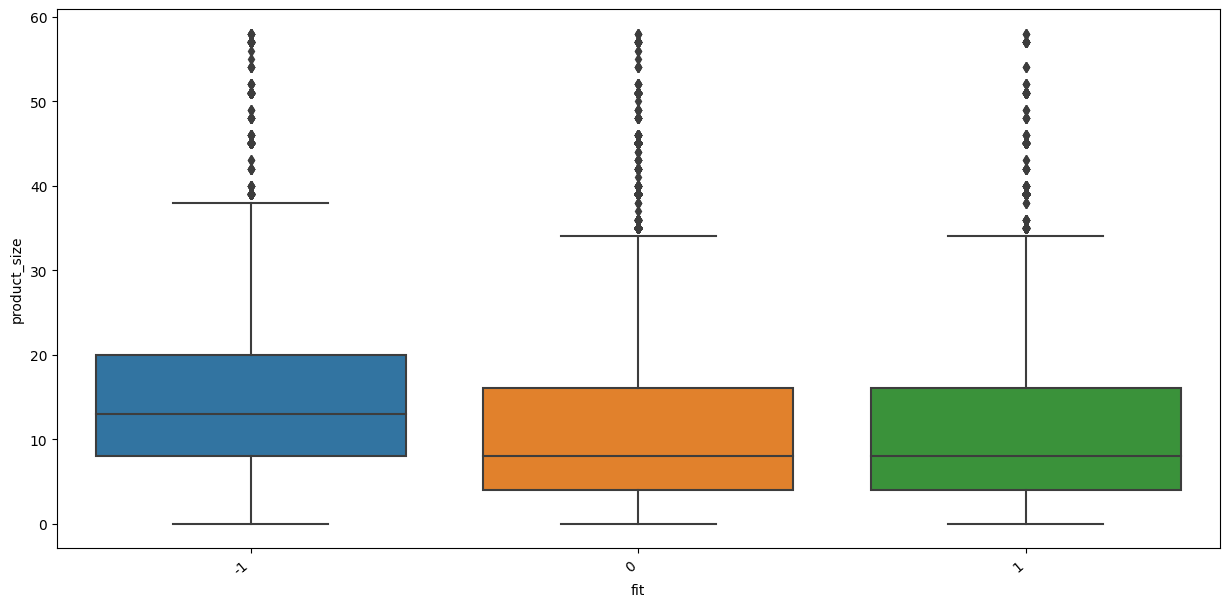

In [13]:
#plotting box plot between fit and product size.
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,7))
ax=sns.boxplot(x='fit',y='product_size',data=newdf)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha='right')
plt.show()

<Axes: xlabel='body_type', ylabel='Count'>

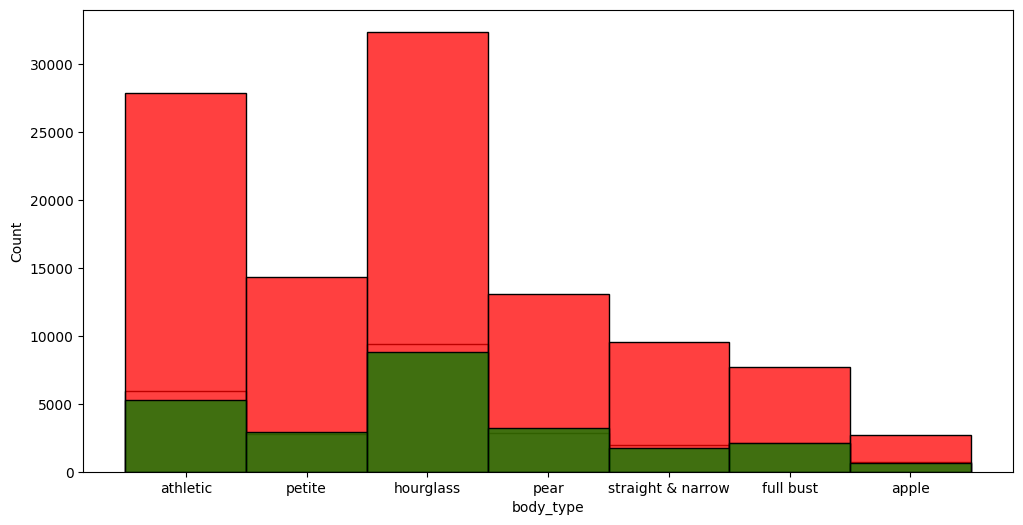

In [14]:
#Plotting histogram between body type and frequency
plt.figure(figsize=(12,6))
sns.histplot(newdf[newdf['fit'] == -1]['body_type'], color='white')
sns.histplot(newdf[newdf['fit'] == 0]['body_type'],color='red')
sns.histplot(newdf[newdf['fit'] == 1]['body_type'],color='green')

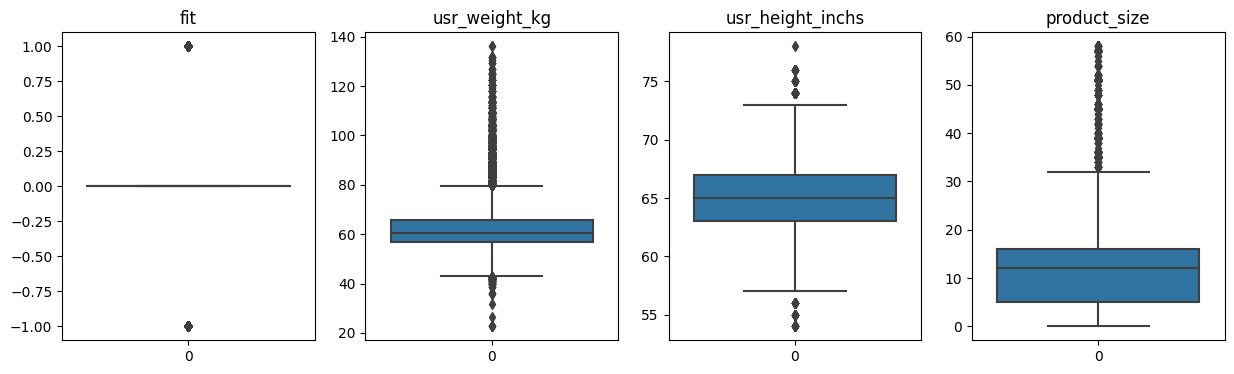

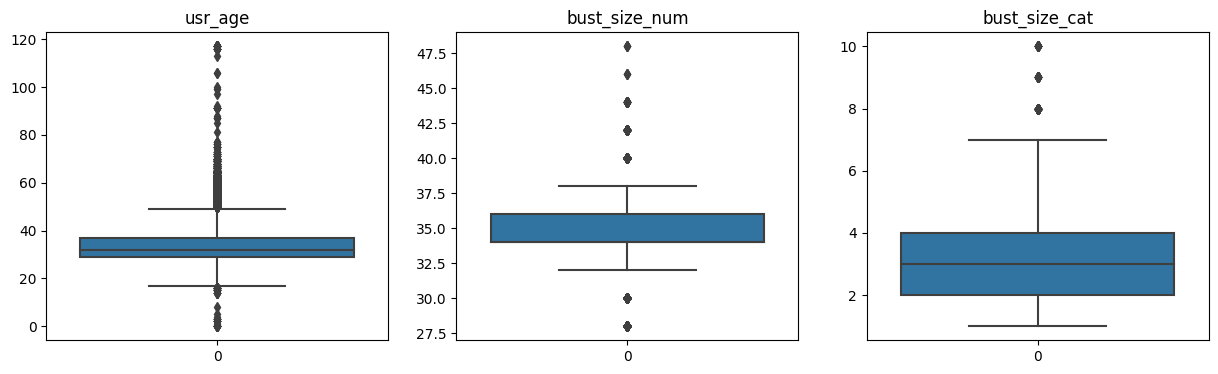

In [15]:
#Plotting boxplots between numerical features.
def draw_boxplots(cols, data, per_line=4):
    n = len(cols)
    per_line = 4
    for i in range(0, n, per_line):
        n_plots = per_line if n - i >= per_line else n % per_line
        fig, axes = plt.subplots(1, n_plots)
        plt.subplots_adjust(wspace=0.2)
        fig.set_figwidth(15)
        fig.set_figheight(4)
        for j in range(n_plots):
            sns.boxplot(data[cols[i + j]], ax=axes[j])
            axes[j].set_title(cols[i + j])  # set the title for the subplot
        plt.show()
draw_boxplots(numeric_features, newdf)

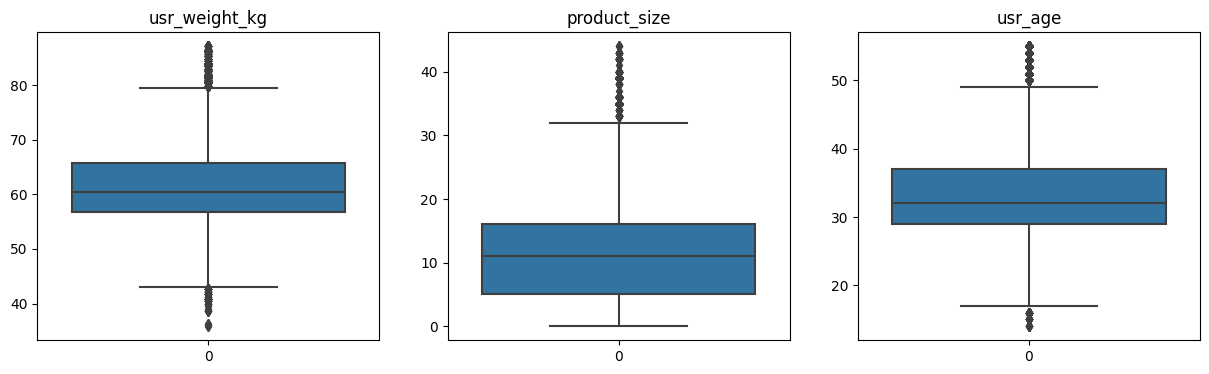

In [16]:
import numpy as np
#finding columns with outliers.
cols_with_outliers = ['usr_weight_kg', 'product_size', 'usr_age']

for c in cols_with_outliers:
    q1, q2, q3 = np.percentile(newdf[c], [25, 50, 75])
    median = q2
    std = 0.7413 * (q3 - q1)
    query_result = newdf.query(f'({c} > @median - 4 * @std) & ({c} < @median + 4 * @std)')[c]
    newdf[c] = query_result
    newdf[c] = newdf[c].fillna(newdf[c].median())
    
draw_boxplots(cols_with_outliers, newdf)

In [17]:
#Finding BMI from height and weight.
newdf['BMI'] = newdf['usr_weight_kg'] / np.power(newdf['usr_height_inchs'], 2)
newdf.drop(['usr_weight_kg', 'usr_height_inchs'], axis=1, inplace=True)

In [18]:

numeric_features.append('BMI')
numeric_features.remove('usr_weight_kg')
numeric_features.remove('usr_height_inchs')

,fit,product_size,usr_age,bust_size_num,bust_size_cat,BMI
fit,1.000000,-0.126449,-0.010123,-0.015816,-0.008531,-0.016115
product_size,-0.126449,1.000000,0.151218,0.601972,0.296678,0.600817
usr_age,-0.010123,0.151218,1.000000,0.169424,0.071238,0.077094
bust_size_num,-0.015816,0.601972,0.169424,1.000000,0.113405,0.460983
bust_size_cat,-0.008531,0.296678,0.071238,0.113405,1.000000,0.272169
BMI,-0.016115,0.600817,0.077094,0.460983,0.272169,1.000000


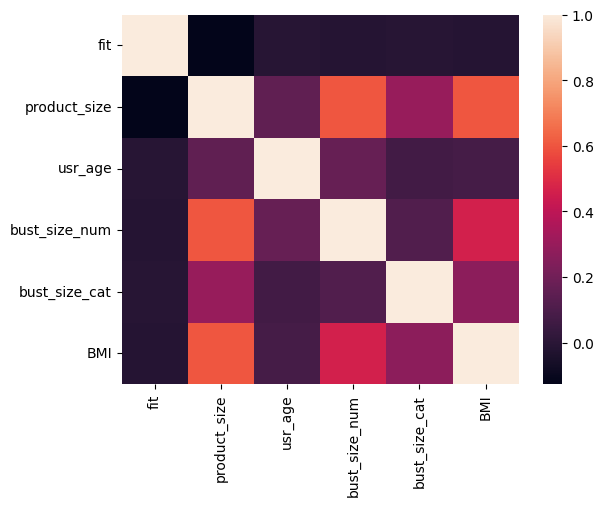

In [19]:
#Finding correlation matrix for new columns.
cleaned_df_scaled = newdf[numeric_features].copy()
cleaned_df_scaled = pd.DataFrame(scale(cleaned_df_scaled), columns=numeric_features)

corr_matrix = cleaned_df_scaled.corr()
sns.heatmap(corr_matrix)
corr_matrix